In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/data')
sys.path.append('../src/collaborative_filtration')
sys.path.append('../src/database_inference')
# from get_users_info import *
# from get_brand_category_info import *
# from get_preference_matrix import *
from get_popular_items import *
import implicit
import faiss
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import precision_score
from itertools import islice
from pymongo import MongoClient
import certifi
from get_train_test_matrices import *
from validation_pipeline import *
from validation_pipeline import *
from collaborative_inference import *
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 1000)

In [94]:
path = str(Path(sys.path[0]).parent) + '/src/data'
sys.path.append(path)
# from get_new_preference_matrix import get_new_pref_matrix, preprocess_single_table

import_path = str(Path(sys.path[0]).parent) + '/data/interim/'

user_item_old = pd.read_csv(import_path + 'user_group_info_old.csv').set_index('ym_client_id')
user_item = pd.read_csv(import_path + 'user_group_info.csv').set_index('ym_client_id')

In [95]:
brand_categ_old = pd.read_csv(import_path + 'brand_category_info_old.csv')
brand_categ_info = pd.read_csv(import_path + 'brand_category_info.csv')

brand_categ_info.set_index(['brand','Группа категорий'], inplace = True)
brand_categ_old.set_index(['brand','Группа категорий'], inplace = True)


brand_categ_info.loc[:,'brand_categ'] = np.array(brand_categ_info.index)
brand_categ_info.brand_categ = brand_categ_info.brand_categ.astype(str)

brand_categ_old.loc[:,'brand_categ'] = np.array(brand_categ_old.index)
brand_categ_old.brand_categ = brand_categ_old.brand_categ.astype(str)

In [96]:
brand_categ_old.sort_values('total_views', ascending = False, inplace=True)
brand_categ_old.loc[:,'recommends'] = 0
brand_categ_old.loc[:30,'recommends'] = 1
brand_categ_old.set_index('brand_categ', inplace=True)

In [97]:
item_user = user_item.T

In [18]:
# матрица предпочтений
# pref_matrix = get_pref_matrix(to_csv=False)
# item_user = pref_matrix.drop(columns=['id_s','id_list','item_total'], index = ['user_total'])
# item_user = pd.read_csv(impo)

In [98]:
user_item_cut = cut_user_item(item_user)

In [99]:
user_item_old_cut = cut_user_item(user_item_old.T)

In [100]:
user_item_old_cut = user_item_old_cut.reindex(columns=user_item_cut.columns, fill_value=0)

In [101]:
user_item_old_cut.index = user_item_old_cut.index.astype(str)

In [102]:
user_item_cut.index = user_item_cut.index.astype(str)

In [103]:
user_item_diff = get_binarized_differences(user_item_cut, user_item_old_cut, do_first='subtract')

In [104]:
user_item_diff.shape

(440, 606)

In [36]:
user_item_diff.to_csv(import_path + 'user_item_diff.csv')

In [14]:
plots = get_validation_plots(user_item_cut, user_item_old_cut, user_item_diff, range_=40)

100%|███████████████████████████████████████████| 35/35 [07:46<00:00, 13.34s/it]


In [15]:
plots_ = get_validation_plots(user_item_cut, user_item_old_cut, user_item_diff, range_=40, method = 'hardcode')

100%|███████████████████████████████████████████| 35/35 [41:22<00:00, 70.94s/it]


In [ ]:
plots_.loc[:,['euclid_mean_precision_10','cosine_mean_precision_10']].plot().set_xlabel('число соседей'),\
plots_.loc[:,['euclid_mean_recall_10','cosine_mean_recall_10']].plot().set_xlabel('число соседей')

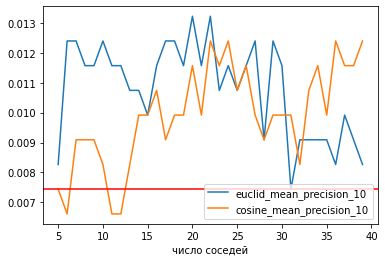

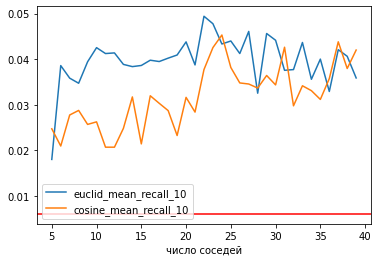

In [19]:
plots.loc[:,['euclid_mean_precision_10','cosine_mean_precision_10']].plot().set_xlabel('число соседей')
plt.axhline(y=get_metrics_at_k(user_item_diff, user_item_cut, user_dict_pop, k=10)[0], color='r', linestyle='-'),\
plots.loc[:,['euclid_mean_recall_10','cosine_mean_recall_10']].plot().set_xlabel('число соседей')
plt.axhline(y=get_metrics_at_k(user_item_diff, user_item_cut, user_dict_pop, k=10)[2], color='r', linestyle='-')

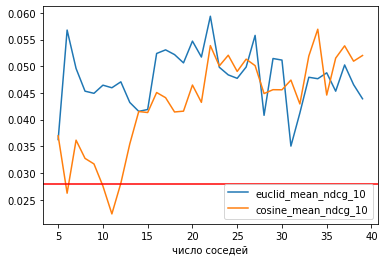

In [20]:
plots.loc[:,['euclid_mean_ndcg_10','cosine_mean_ndcg_10']].plot().set_xlabel('число соседей')
plt.axhline(y=get_metrics_at_k(user_item_diff, user_item_cut, user_dict_pop, k=10)[4], color='r', linestyle='-')

In [21]:
all_plots = plots.join(plots_, rsuffix = '_hardcode')

Text(0, 0.5, 'precision@10')

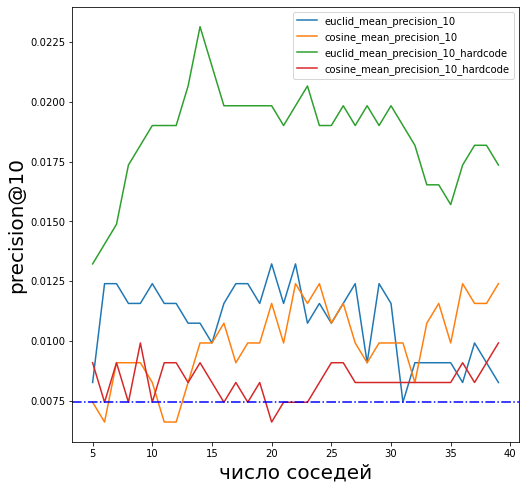

In [27]:
plot1 = all_plots.loc[:,[
    'euclid_mean_precision_10',
    'cosine_mean_precision_10',
    'euclid_mean_precision_10_hardcode',
    'cosine_mean_precision_10_hardcode']].plot(figsize = (8,8))
plt.axhline(y=get_metrics_at_k(user_item_diff, user_item_cut, user_dict_pop, k=10)[0], color='blue', linestyle='-.')
plot1.set_xlabel('число соседей', fontsize = 20)
plot1.set_ylabel('precision@10', fontsize = 20)

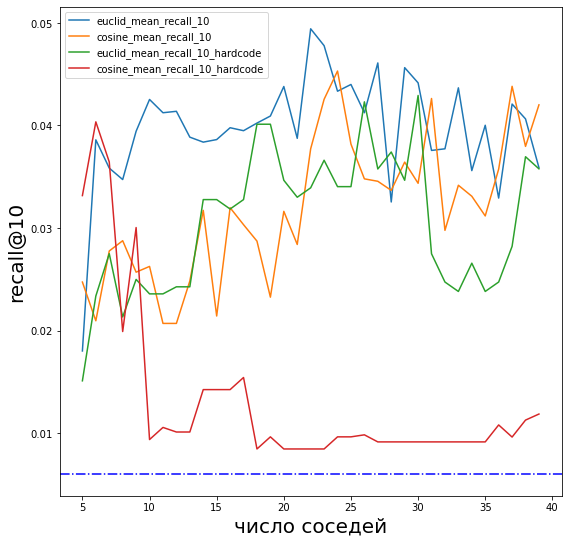

In [28]:
plot2 = all_plots.loc[:,[
    'euclid_mean_recall_10',
    'cosine_mean_recall_10',
    'euclid_mean_recall_10_hardcode',
    'cosine_mean_recall_10_hardcode']].plot(figsize = (9,9))

plot2.set_xlabel('число соседей', fontsize = 20)
plot2.set_ylabel('recall@10', fontsize = 20)
plt.axhline(y=get_metrics_at_k(user_item_diff, user_item_cut, user_dict_pop, k=10)[2], color='blue', linestyle='-.')

In [82]:
get_metrics_at_k(user_item_diff, user_item_cut, user_dict_pop, k=10)[0]

0.007438016528925621

In [85]:
for metric in ['euclid', 'cosine']:
    for method in ['','_hardcode']:
        all_plots.loc[:,f'f_measure_{metric}{method}'] = 2*\
            all_plots[f'{metric}_mean_precision_10{method}']*all_plots[f'{metric}_mean_recall_10{method}']/\
            (all_plots[f'{metric}_mean_precision_10{method}'] + all_plots[f'{metric}_mean_recall_10{method}'])
    
    
    

Text(0, 0.5, 'значения F-меры')

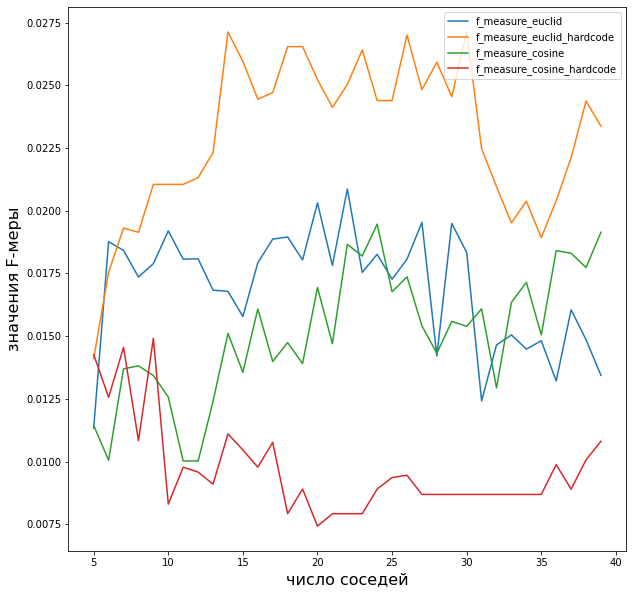

In [88]:
f_plot = all_plots.loc[:,['f_measure_euclid', 
                 'f_measure_euclid_hardcode', 
                 'f_measure_cosine', 
                 'f_measure_cosine_hardcode']].plot(figsize = (10,10))
f_plot.set_xlabel('число соседей', fontsize = 16)
f_plot.set_ylabel('значения F-меры', fontsize = 16)

In [76]:
ndcg_score([[1,1,0,0,0]],[[0,0,0,1,0]])

0.5973461194795789

Text(0.5, 0, 'число соседей')

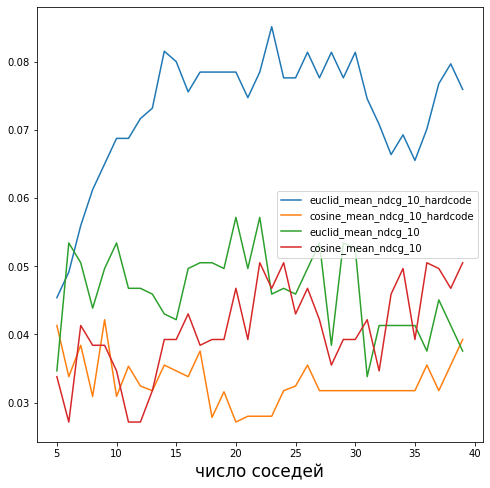

In [80]:
ndcg_plot = all_plots.loc[:,[
    'euclid_mean_ndcg_10_hardcode',
    'cosine_mean_ndcg_10_hardcode',
    'euclid_mean_ndcg_10',
    'cosine_mean_ndcg_10',
]].plot(figsize = (8,8))
ndcg_plot.set_xlabel('число соседей', fontsize = 17)

In [29]:
gb_metrics = pd.read_csv('gradboost_metrics.csv')

In [32]:
gb_metrics

,Unnamed: 0,precision,recall,ndcg,f_score@10
0,10000,0.081818,0.151960,0.231598,0.106366
1,20000,0.114050,0.202278,0.284226,0.145860
2,30000,0.109917,0.201543,0.272596,0.142253
3,40000,0.119835,0.224028,0.340823,0.156146
4,50000,0.122314,0.245043,0.337643,0.163177
5,60000,0.123967,0.252278,0.354531,0.166243
6,70000,0.133058,0.279400,0.342204,0.180267
7,80000,0.134711,0.269987,0.346962,0.179740
8,90000,0.120661,0.233945,0.306230,0.159208
9,100000,0.127273,0.244358,0.317735,0.167371


In [38]:
all_plots['euclid_mean_ndcg_10'].values

array([0.03626973, 0.05676809, 0.04957519, 0.0453309 , 0.04492896,
       0.04645525, 0.04596956, 0.04707893, 0.04322239, 0.04155159,
       0.04190306, 0.0523865 , 0.05306293, 0.05217674, 0.05062697,
       0.05469844, 0.05171903, 0.05935537, 0.04980731, 0.04838001,
       0.04773365, 0.04985075, 0.05577217, 0.04080929, 0.05144417,
       0.05114899, 0.03504964, 0.0412462 , 0.04793562, 0.04766166,
       0.04876459, 0.04532726, 0.05023967, 0.04655256, 0.04390888])

In [39]:
pd.Series( all_plots['euclid_mean_ndcg_10'].values, index=np.arange(0,all_plots.shape[0]))

0     0.036270
1     0.056768
2     0.049575
3     0.045331
4     0.044929
5     0.046455
6     0.045970
7     0.047079
8     0.043222
9     0.041552
10    0.041903
11    0.052387
12    0.053063
13    0.052177
14    0.050627
15    0.054698
16    0.051719
17    0.059355
18    0.049807
19    0.048380
20    0.047734
21    0.049851
22    0.055772
23    0.040809
24    0.051444
25    0.051149
26    0.035050
27    0.041246
28    0.047936
29    0.047662
30    0.048765
31    0.045327
32    0.050240
33    0.046553
34    0.043909
dtype: float64

Text(0.5, 0, 'число соседей')

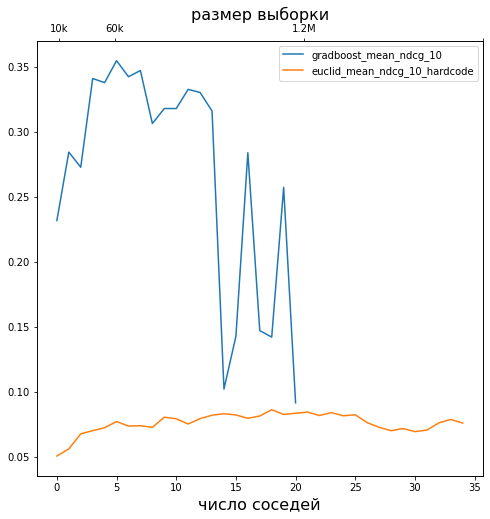

In [83]:
ax1 = pd.concat([
    pd.Series(gb_metrics['ndcg'], name = 'gradboost_mean_ndcg_10'), 
    pd.Series( all_plots['euclid_mean_ndcg_10_hardcode'].values, 
              index=np.arange(0,all_plots.shape[0]), 
              name='euclid_mean_ndcg_10_hardcode')], axis = 1
         ).plot(figsize = (8,8))
ax2 = ax1.twiny()
new_tick_locations = np.array([10, 35, 120,200])

def tick_function(X):
    V = X
    return ["%.3f" % z for z in V]


ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(['10k','60k','1.2M',''])
ax2.set_xlabel('размер выборки', fontsize = 16)
ax1.set_xlabel('число соседей', fontsize = 16)

In [46]:
plot_ndcg.get_xbound()

(-1.7000000000000002, 35.7)

In [105]:
user_dict = recommend_NN(user_item_cut=user_item_old_cut, 
                          user_item_cut_index=user_item_old_cut.index, 
                          k=20,
                          method='faiss',
                          metric = 'euclid',
                          inference=True)

In [107]:
user_item

,"('1017 ALYX 9SM', 'Футболки и лонгсливы')","('11 By Boris Bidjan Saberi', 'Футболки и лонгсливы')","('11 By Boris Bidjan Saberi', 'Штаны и брюки')","('3.1 Phillip Lim', 'Пиджаки и жилеты')","('3.1 Phillip Lim', 'Рубашки')","('3.1 Phillip Lim', 'Футболки и лонгсливы')","('99%Is', 'Штаны и брюки')","('A Cold Wall', 'Сумки и кошельки')","('A Cold Wall', 'Футболки и лонгсливы')","('AMI', 'Куртки и пуховики')","('AMI', 'Пальто и плащи')","('Acne Studios', 'Ботинки и сапоги')","('Acne Studios', 'Деним')","('Acne Studios', 'Джемперы и свитеры')","('Acne Studios', 'Куртки и пуховики')","('Acne Studios', 'Пальто и плащи')","('Acne Studios', 'Сандалии и тапочки')","('Acne Studios', 'Свитшоты и худи')","('Acne Studios', 'Футболки и лонгсливы')","('Acne Studios', 'Шорты и плавки')","('Acne Studios', 'Штаны и брюки')","('Acronym', 'Кроссовки и кеды')","('Adam Kimmel', 'Пиджаки и жилеты')","('Adam Kimmel', 'Штаны и брюки')","('Ader Error', 'Шарфы, платки, перчатки')","('Adidas', 'Кроссовки и кеды')","('Adidas', 'Куртки и пуховики')","('Air Jordan', 'Кроссовки и кеды')","('Alanui', 'Джемперы и свитеры')","('Alanui', 'Шарфы, платки, перчатки')","('Alanui', 'Штаны и брюки')","('Alexander Digenova ', 'Джемперы и свитеры')","('Alexander Digenova ', 'Рубашки')","('Alexander Digenova ', 'Свитшоты и худи')","('Alexander McQueen', 'Джемперы и свитеры')","('Alexander McQueen', 'Футболки и лонгсливы')","('Alexander McQueen', 'Шарфы, платки, перчатки')","('Alexander Wang', 'Ботинки и сапоги')","('Alexander Wang', 'Платья')","('Alexander Wang', 'Футболки и лонгсливы')","('Allsaints', 'Футболки и лонгсливы')","('Ambush Design', 'Свитшоты и худи')","('Amiri', 'Ботинки и сапоги')","('Amiri', 'Деним')","('Amiri', 'Кроссовки и кеды')","('Amiri', 'Куртки и пуховики')","('Amiri', 'Рубашки')","('Andrea Yaaqov', 'Рубашки')","('Andy Wolf', 'Очки')","('Ann Demeulemeester', 'Пиджаки и жилеты')","('Ann Demeulemeester', 'Рубашки')","('Ann Demeulemeester', 'Штаны и брюки')","('Attachment', 'Пальто и плащи')","('Attachment', 'Рубашки')","('Attachment', 'Футболки и лонгсливы')","('Automatic Vertical', 'Джемперы и свитеры')","('Azs Tokyo', 'Головные уборы')","('Backlash', 'Кожаные куртки')","('Balenciaga', 'Джемперы и свитеры')","('Balenciaga', 'Кроссовки и кеды')","('Balenciaga', 'Куртки и пуховики')","('Balenciaga', 'Пальто и плащи')","('Balenciaga', 'Пиджаки и жилеты')","('Balenciaga', 'Рубашки')","('Balenciaga', 'Свитшоты и худи')","('Balenciaga', 'Сумки и кошельки')","('Balenciaga', 'Туфли')","('Balenciaga', 'Футболки и лонгсливы')","('Balenciaga', 'Штаны и брюки')","('Balmain', 'Ботинки и сапоги')","('Balmain', 'Деним')","('Balmain', 'Джемперы и свитеры')","('Balmain', 'Пиджаки и жилеты')","('Balmain', 'Рубашки')","('Balmain', 'Свитшоты и худи')","('Balmain', 'Футболки и лонгсливы')","('Balmain', 'Штаны и брюки')","('Bape', 'Свитшоты и худи')","('Bape', 'Футболки и лонгсливы')","('Bears Heal Tears', 'Украшения и другое')","('Ben Taverniti Unravel Project', 'Куртки и пуховики')","('Ben Taverniti Unravel Project', 'Футболки и лонгсливы')","('Ben Taverniti Unravel Project', 'Штаны и брюки')","('Bernhard Willhelm', 'Свитшоты и худи')","('Boris Bidjan Saberi', 'Ботинки и сапоги')","('Boris Bidjan Saberi', 'Деним')","('Boris Bidjan Saberi', 'Кожаные куртки')","('Boris Bidjan Saberi', 'Кроссовки и кеды')","('Boris Bidjan Saberi', 'Куртки и пуховики')","('Boris Bidjan Saberi', 'Рубашки')","('Boris Bidjan Saberi', 'Свитшоты и худи')","('Boris Bidjan Saberi', 'Туфли')","('Boris Bidjan Saberi', 'Футболки и лонгсливы')","('Boris Bidjan Saberi', 'Штаны и брюки')","('Borsalino', 'Головные уборы')","('Bottega Veneta', 'Ботинки и сапоги')","('Bottega Veneta', 'Джемперы и свитеры')","('Bottega Veneta', 'Кроссовки и кеды')","('Bottega Veneta', 'Пиджаки и жилеты')","('Bottega Veneta', 'Сандалии и тапочки')","('Bottega Veneta', 'Сумки и кошельки')","('Bottega Veneta', 'Туфли')","('Bottega Veneta', 'Штаны и брюки')","('Brioni', 'Деним')","('Brioni', 'Джемперы и свитеры')","('Brioni',

In [14]:
path__ = path_to_repo + '/recommendations/data/raw'
# pref_matrix = get_pref_matrix(path_to_repo= path_to_repo, to_csv=False)

vygruz = pd.read_excel(os.path.join(path__, 'goods.xlsx'))
vygruz = vygruz.loc[vygruz.id != '']
vygruz = vygruz.loc[~vygruz.id.isnull()]
vygruz = vygruz[vygruz['id'].str.isnumeric()]
vygruz = vygruz.loc[(~vygruz['Пол'].isna())]
vygruz['id'] = vygruz.id.replace('', np.nan, regex=False).astype(int)
vygruz.loc[:, 'id_s'] = vygruz.id.astype(str)
stock = vygruz.loc[(vygruz.reason == 'Приемка')].groupby(['brand','Группа категорий']).agg({'id_s': list})
stock.loc[:,'brand_categ'] = [str(i) for i in stock.index]
stock.set_index('brand_categ', inplace=True)
id_dict = stock.to_dict()['id_s']

In [15]:
with open(path_to_repo+'/mongodb_pass.txt', 'r') as file:
    path2 = file.read()
client = MongoClient(path2,  tlsCAFile=certifi.where())
current_db = client['spin_services']

In [66]:
recommends_collection = []
new_recs_male, new_recs_fem = get_popular_items(current_db)
for user in user_dict:
    user_recs = {}
    user_recs['_id'] = str(user)
    recs_categ = user_dict[user]['recommends'].sort_values(ascending=False).head(5).index
    recs_id = [id_dict.get(categ) for categ in recs_categ]

    # собираем сортированный из чередующихся категорий
    recs_id_sorted = []
    recs_id = [l if l != None else [] for l in recs_id]
    max_len = max([len(l) for l in recs_id])
    for i in range(max_len):
        for list_ in recs_id:
            if i <= len(list_) - 1:
                recs_id_sorted.append(list_[i])
                
    male = list(vygruz.loc[(vygruz['reason'] == 'Приемка')&(vygruz['Пол']!='female')]['id'].astype(str))
    female = list(vygruz.loc[(vygruz['reason'] == 'Приемка')&(vygruz['Пол']!='male')]['id'].astype(str))
    
    #отбираем однополые рекомендации
    male_recs = [i for i in recs_id_sorted if i in male]
    male_recs.extend(new_recs_male)

    fem_recs = [i for i in recs_id_sorted if i in female]
    fem_recs.extend(new_recs_fem)
    
    user_recs['recommends'] = recs_id_sorted
    user_recs['recommends_male'] = male_recs
    user_recs['recommends_fem'] = fem_recs
    recommends_collection.append(user_recs)
recommends_collection.append({
    '_id': 'new',
    'recommends_male': new_recs_male,
    'recommends_fem': new_recs_fem
})

In [68]:
recs_id_sorted

['2000000094953',
 '2000000086927',
 '2000000008493',
 '2000000003603',
 '2000000113487',
 '2000000099071',
 '2000000112572',
 '2000000076577',
 '2000000003634',
 '2000000131221',
 '2000000099088',
 '2000000142104',
 '2000000059730',
 '2000000138831']

In [69]:
id = '2000000094953'

In [93]:
pd.DataFrame(current_db['vygruz_col'].find({},{'Пол':1})).set_index('_id').to_dict()['Пол']
# .get(id)

{'2000000011233': 'male',
 '2000000013039': 'male',
 '2000000008714': 'male',
 '2000000003801': 'male',
 '2000000013046': 'male',
 '2000000007250': 'male',
 '2000000008646': 'male',
 '2000000014548': nan,
 '2000000007267': 'male',
 '2000000011264': 'male',
 '2000000010625': 'male',
 '2000000008523': 'male',
 '2000000011257': 'male',
 '2000000011240': 'male',
 '2000000002385': 'male',
 '2000000008653': 'male',
 '2000000003733': 'male',
 '2000000002378': 'male',
 '2000000011288': 'male',
 '2000000011301': 'male',
 '2000000013695': 'male',
 '2000000013657': 'male',
 '2000000013688': 'male',
 '2000000013671': 'male',
 '2000000013664': 'male',
 '2000000008318': 'male',
 '2000000010762': nan,
 '2000000000398': 'male',
 '2000000007533': 'male',
 '2000000004730': 'male',
 '2000000010779': 'male',
 '2000000007854': 'male',
 '2000000002453': 'male',
 '2000000000411': 'male',
 '2000000003818': 'male',
 '2000000013701': 'male',
 '2000000014036': 'male',
 '2000000008752': 'male',
 '2000000010199': 

<AxesSubplot:ylabel='ym_client_id'>

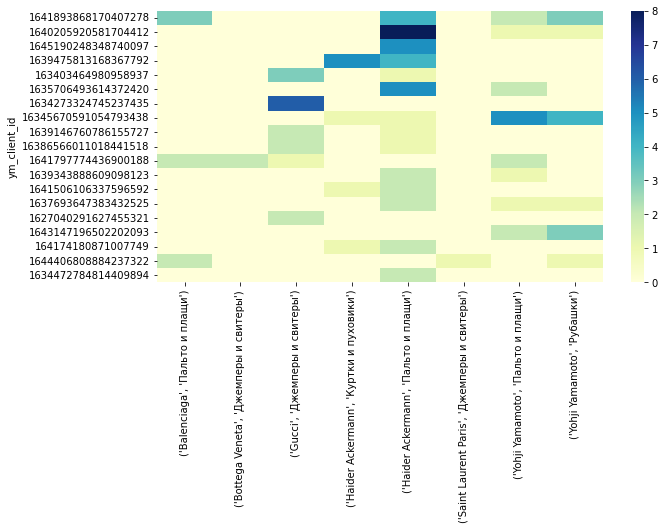

In [36]:
neigh = user_dict_['16503128461049233105']['neighbours'].drop(index = 'preferred_bin')
plt.figure(figsize = (10,5))
sns.heatmap(neigh.T.loc[user_dict_['16503128461049233105']['preferred_exact']>0].T, cmap="YlGnBu")

In [31]:
user_dict_ = recommend_NN(user_item_cut=user_item_old_cut, 
                          user_item_cut_index=user_item_old_cut.index, 
                          k=20,
                          method='faiss',
                          metric = 'euclid',
                          inference=True)

In [17]:
user_dict_pop = recommend_NN(user_item_cut=user_item_old_cut, 
                          user_item_cut_index=user_item_old_cut.index, 
                          k=20,
                          method='faiss',
                          metric = 'euclid', inference=True)

In [18]:
for user in user_dict_pop:
    user_dict_pop[user]['recommends'] = brand_categ_old['recommends'].loc[brand_categ_old.index.isin(user_item_diff.columns)]
    

In [36]:
get_metrics_at_k(user_item_diff, user_item_cut, user_dict_pop, k=10)

(0.007438016528925621,
 0.2,
 0.006073005210098063,
 0.2,
 0.027984528350157307,
 0.5571741306624307)

In [37]:
get_metrics_at_k(user_item_diff, user_item_cut, user_dict_, k=10)

(0.010743801652892562,
 0.2,
 0.025388056549942792,
 1.0,
 0.040099288666521765,
 0.5571741306624307)

In [13]:
def plot_neighbors_dist(user_dict_):
    dist_stat = {}
    for user in user_dict_:
        len_pref = user_dict_[user]['preferred_binary'].sum()
        dist_stat[user] = {}
        dist_stat[user]['len_pref'] = len_pref
        for i in range(1,len(user_dict_[user]['distance'])):
            mean_dist = np.mean(user_dict_[user]['distance'][:i])
            dist_stat[user][f'mean_dist_{i}'] = mean_dist


    pref_lenghts = pd.DataFrame(dist_stat).T

    pref_lenghts.loc[:,'group'] = np.where(
        pref_lenghts.len_pref < 5, 
        '<5 взаимодействий', 
        np.where(
            pref_lenghts.len_pref < 15,
            '5-15',
            '>15'
        ))

    plot_df = pref_lenghts.groupby('group').mean().T.set_index(np.arange(20)).iloc[1:,:]
    plot = plot_df.plot()
    plot.set_xlabel('k соседей')
    plot.set_ylabel('косинусное расстояние до первых k соседей')
    return plot_df, plot

In [22]:
dist_stat = {}
for user in user_dict__:
    len_pref = user_dict__[user]['preferred_binary'].sum()
    dist_stat[user] = {}
    dist_stat[user]['len_pref'] = len_pref
    for i in range(1,len(user_dict__[user]['distance'])):
        mean_dist = np.mean(user_dict__[user]['distance'][:i])
        dist_stat[user][f'mean_dist_{i}'] = mean_dist


pref_lenghts = pd.DataFrame(dist_stat).T

In [28]:
user_dict__['1586517765142996502']['distance'], user_dict_['1586517765142996502']['distance']

([74.18220810949214,
  49.25444142409901,
  37.36308338453881,
  26.870057685088806,
  23.08679276123039,
  23.0,
  20.29778313018444,
  20.248456731316587,
  18.867962264113206,
  18.520259177452136,
  16.522711641858304,
  16.3707055437449,
  15.652475842498529,
  15.231546211727817,
  15.0996688705415,
  15.0,
  14.7648230602334,
  14.45683229480096,
  14.247806848775006,
  14.0],
 array([ 0., 37., 38., 38., 41., 42., 42., 42., 44., 44., 44., 44., 44.,
        44., 45., 45., 46., 46., 46., 46.], dtype=float32))

<AxesSubplot:>

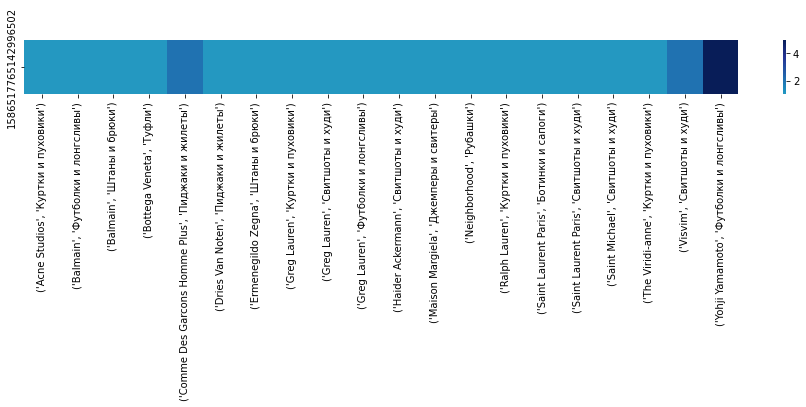

In [45]:
user__ = user_item_cut.loc['1586517765142996502'].to_frame()
plt.figure(figsize = (16,1))
sns.heatmap(user__.loc[user__['1586517765142996502'] > 0].T, cmap="YlGnBu", center=0, linewidths=0)

<AxesSubplot:>

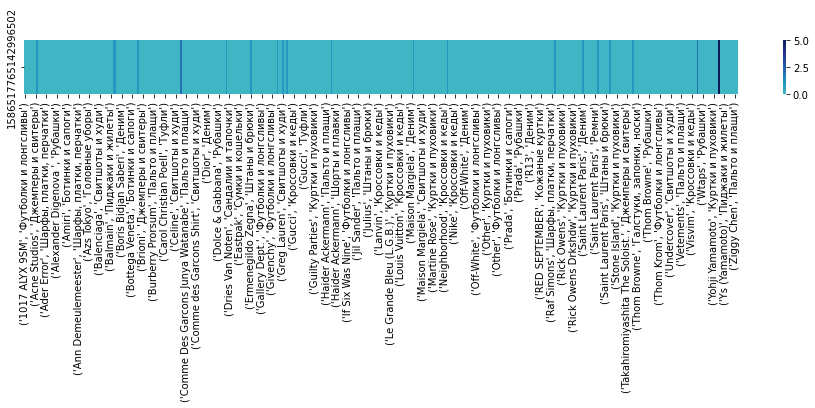

In [46]:
plt.figure(figsize = (16,1))
sns.heatmap(user__.T, cmap="YlGnBu", center=0, square=False)

In [47]:
user_item_old

,"('1017 ALYX 9SM', 'Футболки и лонгсливы')","('11 By Boris Bidjan Saberi', 'Свитшоты и худи')","('11 By Boris Bidjan Saberi', 'Футболки и лонгсливы')","('99%Is', 'Штаны и брюки')","('A Cold Wall', 'Сумки и кошельки')","('A Cold Wall', 'Футболки и лонгсливы')","('Acne Studios', 'Ботинки и сапоги')","('Acne Studios', 'Деним')","('Acne Studios', 'Джемперы и свитеры')","('Acne Studios', 'Куртки и пуховики')","('Acne Studios', 'Свитшоты и худи')","('Acne Studios', 'Футболки и лонгсливы')","('Acne Studios', 'Штаны и брюки')","('Adam Kimmel', 'Пиджаки и жилеты')","('Adam Kimmel', 'Штаны и брюки')","('Ader Error', 'Шарфы, платки, перчатки')","('Adidas', 'Кроссовки и кеды')","('Adidas', 'Куртки и пуховики')","('Air Jordan', 'Кроссовки и кеды')","('Alanui', 'Джемперы и свитеры')","('Alanui', 'Шарфы, платки, перчатки')","('Alanui', 'Штаны и брюки')","('Alexander Digenova ', 'Джемперы и свитеры')","('Alexander Digenova ', 'Рубашки')","('Alexander Digenova ', 'Свитшоты и худи')","('Alexander McQueen', 'Джемперы и свитеры')","('Alexander McQueen', 'Кроссовки и кеды')","('Alexander McQueen', 'Куртки и пуховики')","('Alexander McQueen', 'Футболки и лонгсливы')","('Alexander Wang', 'Футболки и лонгсливы')","('Allsaints', 'Футболки и лонгсливы')","('Amiri', 'Ботинки и сапоги')","('Amiri', 'Деним')","('Amiri', 'Кроссовки и кеды')","('Amiri', 'Рубашки')","('Andrea Yaaqov', 'Штаны и брюки')","('Andy Wolf', 'Очки')","('Ann Demeulemeester', 'Пиджаки и жилеты')","('Ann Demeulemeester', 'Рубашки')","('Ann Demeulemeester', 'Шарфы, платки, перчатки')","('Ann Demeulemeester', 'Штаны и брюки')","('Archvio J.M. Ribot', 'Пиджаки и жилеты')","('Archvio J.M. Ribot', 'Рубашки')","('Attachment', 'Пальто и плащи')","('Attachment', 'Пиджаки и жилеты')","('Attachment', 'Футболки и лонгсливы')","('Automatic Vertical', 'Джемперы и свитеры')","('Azs Tokyo', 'Головные уборы')","('Backlash', 'Кожаные куртки')","('Balenciaga', 'Джемперы и свитеры')","('Balenciaga', 'Кроссовки и кеды')","('Balenciaga', 'Куртки и пуховики')","('Balenciaga', 'Пальто и плащи')","('Balenciaga', 'Пиджаки и жилеты')","('Balenciaga', 'Рубашки')","('Balenciaga', 'Свитшоты и худи')","('Balenciaga', 'Сумки и кошельки')","('Balenciaga', 'Футболки и лонгсливы')","('Balenciaga', 'Штаны и брюки')","('Balmain', 'Ботинки и сапоги')","('Balmain', 'Деним')","('Balmain', 'Джемперы и свитеры')","('Balmain', 'Куртки и пуховики')","('Balmain', 'Пиджаки и жилеты')","('Balmain', 'Свитшоты и худи')","('Balmain', 'Футболки и лонгсливы')","('Balmain', 'Штаны и брюки')","('Bears Heal Tears', 'Украшения и другое')","('Ben Taverniti Unravel Project', 'Куртки и пуховики')","('Ben Taverniti Unravel Project', 'Футболки и лонгсливы')","('Ben Taverniti Unravel Project', 'Штаны и брюки')","('Boris Bidjan Saberi', 'Деним')","('Boris Bidjan Saberi', 'Кожаные куртки')","('Boris Bidjan Saberi', 'Куртки и пуховики')","('Boris Bidjan Saberi', 'Рубашки')","('Boris Bidjan Saberi', 'Свитшоты и худи')","('Boris Bidjan Saberi', 'Туфли')","('Boris Bidjan Saberi', 'Штаны и брюки')","('Borsalino', 'Головные уборы')","('Bottega Veneta', 'Ботинки и сапоги')","('Bottega Veneta', 'Джемперы и свитеры')","('Bottega Veneta', 'Кроссовки и кеды')","('Bottega Veneta', 'Сандалии и тапочки')","('Bottega Veneta', 'Туфли')","('Bottega Veneta', 'Украшения и другое')","('Bottega Veneta', 'Штаны и брюки')","('Brioni', 'Деним')","('Brioni', 'Джемперы и свитеры')","('Brioni', 'Пальто и плащи')","('Brioni', 'Ремни')","('Brunello Cucinelli', 'Штаны и брюки')","('Burberry', 'Куртки и пуховики')","('Burberry', 'Пальто и плащи')","('Burberry', 'Пиджаки и жилеты')","('Burberry', 'Рубашки')","('Burberry Prorsum', 'Пальто и плащи')","('Burberry Prorsum', 'Штаны и брюки')","('C2h4', 'Сумки и кошельки')","('Ca4la', 'Головные уборы')","('Calvin Klein 205W39NYC', 'Джемперы и свитеры')","('Canada Goose', 'Куртки и пуховики')","('Carol Christian Poell', 'Кожаные куртки')","('Carol Christian Poell', 'Пиджаки и жилеты')","('Carol Christian Poell', 'Туфли')","('Cav Empt'

In [23]:
pref_lenghts

,len_pref,mean_dist_1,mean_dist_2,mean_dist_3,mean_dist_4,mean_dist_5,mean_dist_6,mean_dist_7,mean_dist_8,mean_dist_9,mean_dist_10,mean_dist_11,mean_dist_12,mean_dist_13,mean_dist_14,mean_dist_15,mean_dist_16,mean_dist_17,mean_dist_18,mean_dist_19
1586517765142996502,20.0,74.182208,61.718325,53.599911,46.917448,42.151317,38.959431,36.293481,34.287853,32.574532,31.169104,29.837614,28.715372,27.710534,26.819177,26.037877,25.348010,24.725469,24.154989,23.633559
1587819907779396547,9.0,321.009346,181.570047,134.038148,109.192473,93.357311,82.797759,74.460020,67.810054,62.409978,58.087313,54.314205,51.142027,48.387234,45.958681,43.853935,41.967739,40.288249,38.650938,37.163641
1588086482831295602,11.0,29.715316,23.885393,21.491360,19.775704,18.691104,17.956396,17.105482,16.392516,15.783205,15.263185,14.837714,14.455150,14.120101,13.825808,13.567412,13.315661,13.087327,12.881410,12.697169
1589124488521527290,4.0,16.093477,14.170463,13.488427,12.750234,12.065663,11.609282,11.252304,10.942636,10.550810,10.120229,9.738033,9.390511,9.096454,8.844404,8.567472,8.325156,8.111348,7.921296,7.751249
1589202270114292505,35.0,64.753378,59.971979,54.723549,50.073857,47.010345,44.624548,42.896314,41.588594,40.477765,39.566866,38.786594,38.117470,37.516012,36.992210,36.531610,36.098216,35.709836,35.325532,34.977104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650304776991154170,6.0,10.723805,10.485378,10.340211,10.073563,9.720175,9.474514,9.151170,8.845799,8.574391,8.264674,8.011270,7.725545,7.483778,7.276550,7.096951,6.939803,6.801142,6.677889,6.567609
1650311981683136669,8.0,25.119713,22.782381,21.711716,20.967535,20.368468,19.969090,19.590722,19.292463,18.977975,18.609884,18.203725,17.838437,17.492532,17.190672,16.926545,16.666582,16.437203,16.233311,16.050882
16503128461049233105,8.0,20.832667,20.290542,19.973388,19.657113,19.467348,19.340837,19.250473,19.182700,19.129987,19.087817,19.053314,19.024562,19.000233,18.979380,18.961307,18.945493,18.931540,18.919137,18.908040
1650320833766760716,5.0,49.040799,36.042118,30.719699,27.816017,25.520841,23.130757,21.423555,20.020365,18.814230,17.769467,16.903717,16.101750,15.423162,14.841515,14.332821,13.832305,13.381252,12.952119,12.553858


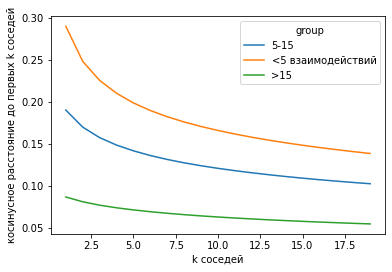

In [18]:
plot_df_f, plot_f = plot_neighbors_dist(user_dict_=user_dict_)

In [19]:
plot_df_h

group,5-15,<5 взаимодействий,>15
1,79.221921,59.006873,150.078327
2,53.770336,40.204596,105.552248
3,43.195637,32.496582,84.877143
4,37.186762,27.975960,73.160512
5,33.163055,24.905580,65.505039
6,30.231120,22.651998,60.012056
7,27.959309,20.905699,55.806956
8,26.129545,19.496378,52.459298
9,24.619388,18.326461,49.706416
10,23.343985,17.333040,47.400032


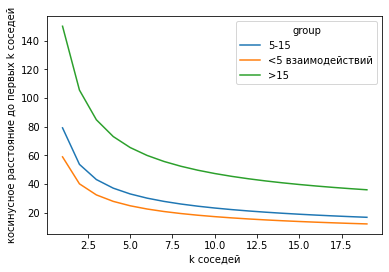

In [14]:
plot_df_h, plot_h = plot_neighbors_dist(user_dict_=user_dict__)

In [40]:
metric_df = pd.concat([user_dict_['16503128461049233105']['recommends'], 
           user_dict_['16503128461049233105']['preferred_exact']], 
          axis =1).sort_values('recommended', ascending = False).head(20)
metric_df.columns = ['recommends', 'preferred']

In [47]:
metric_df.apply(lambda x: round(x,2))

,recommends,preferred
"('Haider Ackermann', 'Пальто и плащи')",2.11,10.0
"('Gucci', 'Джемперы и свитеры')",0.84,10.0
"('Yohji Yamamoto', 'Пальто и плащи')",0.84,5.0
"('Yohji Yamamoto', 'Рубашки')",0.68,5.0
"('Haider Ackermann', 'Куртки и пуховики')",0.42,5.0
"('Balenciaga', 'Пальто и плащи')",0.37,5.0
"('Haider Ackermann', 'Рубашки')",0.37,0.0
"('Yohji Yamamoto', 'Штаны и брюки')",0.37,0.0
"('Haider Ackermann', 'Джемперы и свитеры')",0.32,0.0
"('Haider Ackermann', 'Пиджаки и жилеты')",0.32,0.0


In [61]:
id_dict = pref_matrix.id_list.drop(index='user_total').to_dict()

In [62]:
path_to_repo = '/Users/kuznetsovnikita/recommendations' 
with open(path_to_repo+'/src/data/mongodb_pass.txt', 'r') as file:
    path2 = file.read()

client = MongoClient(path2,  tlsCAFile=certifi.where())
current_db = client['spin_services']

In [63]:
recommends_collection = get_recommends_collection(user_dict_, current_db, id_dict)

In [66]:
recommends_col_db = current_db['recommends']
recommends_col_db.delete_many({})
recommends_col_db.insert_many(recommends_collection)

### подсчет nDCG

In [49]:
from sklearn.metrics import ndcg_score

In [51]:
user_dict_['16503128461049233105']['predict_exact_new'].sort_values()

KeyError: 'predict_exact_new'

In [54]:
user_item_diff

,"('1017 ALYX 9SM', 'Футболки и лонгсливы')","('11 By Boris Bidjan Saberi', 'Свитшоты и худи')","('11 By Boris Bidjan Saberi', 'Футболки и лонгсливы')","('99%Is', 'Штаны и брюки')","('A Cold Wall', 'Сумки и кошельки')","('A Cold Wall', 'Футболки и лонгсливы')","('Acne Studios', 'Ботинки и сапоги')","('Acne Studios', 'Деним')","('Acne Studios', 'Джемперы и свитеры')","('Acne Studios', 'Куртки и пуховики')","('Acne Studios', 'Свитшоты и худи')","('Acne Studios', 'Футболки и лонгсливы')","('Acne Studios', 'Штаны и брюки')","('Acronym', 'Кроссовки и кеды')","('Adam Kimmel', 'Пиджаки и жилеты')","('Adam Kimmel', 'Штаны и брюки')","('Ader Error', 'Шарфы, платки, перчатки')","('Adidas', 'Кроссовки и кеды')","('Adidas', 'Куртки и пуховики')","('Air Jordan', 'Кроссовки и кеды')","('Alanui', 'Джемперы и свитеры')","('Alanui', 'Шарфы, платки, перчатки')","('Alanui', 'Штаны и брюки')","('Alexander Digenova ', 'Джемперы и свитеры')","('Alexander Digenova ', 'Рубашки')","('Alexander Digenova ', 'Свитшоты и худи')","('Alexander McQueen', 'Джемперы и свитеры')","('Alexander McQueen', 'Кроссовки и кеды')","('Alexander McQueen', 'Куртки и пуховики')","('Alexander McQueen', 'Футболки и лонгсливы')","('Alexander Wang', 'Футболки и лонгсливы')","('Allsaints', 'Футболки и лонгсливы')","('Amiri', 'Ботинки и сапоги')","('Amiri', 'Деним')","('Amiri', 'Кроссовки и кеды')","('Amiri', 'Рубашки')","('Andrea Yaaqov', 'Штаны и брюки')","('Andy Wolf', 'Очки')","('Ann Demeulemeester', 'Пиджаки и жилеты')","('Ann Demeulemeester', 'Рубашки')","('Ann Demeulemeester', 'Шарфы, платки, перчатки')","('Ann Demeulemeester', 'Штаны и брюки')","('Archvio J.M. Ribot', 'Пиджаки и жилеты')","('Archvio J.M. Ribot', 'Рубашки')","('Attachment', 'Пальто и плащи')","('Attachment', 'Пиджаки и жилеты')","('Attachment', 'Футболки и лонгсливы')","('Automatic Vertical', 'Джемперы и свитеры')","('Azs Tokyo', 'Головные уборы')","('Backlash', 'Кожаные куртки')","('Balenciaga', 'Джемперы и свитеры')","('Balenciaga', 'Кроссовки и кеды')","('Balenciaga', 'Куртки и пуховики')","('Balenciaga', 'Пальто и плащи')","('Balenciaga', 'Пиджаки и жилеты')","('Balenciaga', 'Рубашки')","('Balenciaga', 'Свитшоты и худи')","('Balenciaga', 'Сумки и кошельки')","('Balenciaga', 'Футболки и лонгсливы')","('Balenciaga', 'Штаны и брюки')","('Balmain', 'Ботинки и сапоги')","('Balmain', 'Деним')","('Balmain', 'Джемперы и свитеры')","('Balmain', 'Куртки и пуховики')","('Balmain', 'Пиджаки и жилеты')","('Balmain', 'Свитшоты и худи')","('Balmain', 'Футболки и лонгсливы')","('Balmain', 'Штаны и брюки')","('Bears Heal Tears', 'Украшения и другое')","('Ben Taverniti Unravel Project', 'Куртки и пуховики')","('Ben Taverniti Unravel Project', 'Футболки и лонгсливы')","('Ben Taverniti Unravel Project', 'Штаны и брюки')","('Boris Bidjan Saberi', 'Деним')","('Boris Bidjan Saberi', 'Кожаные куртки')","('Boris Bidjan Saberi', 'Куртки и пуховики')","('Boris Bidjan Saberi', 'Рубашки')","('Boris Bidjan Saberi', 'Свитшоты и худи')","('Boris Bidjan Saberi', 'Туфли')","('Boris Bidjan Saberi', 'Штаны и брюки')","('Borsalino', 'Головные уборы')","('Bottega Veneta', 'Ботинки и сапоги')","('Bottega Veneta', 'Джемперы и свитеры')","('Bottega Veneta', 'Кроссовки и кеды')","('Bottega Veneta', 'Сандалии и тапочки')","('Bottega Veneta', 'Туфли')","('Bottega Veneta', 'Украшения и другое')","('Bottega Veneta', 'Штаны и брюки')","('Brioni', 'Деним')","('Brioni', 'Джемперы и свитеры')","('Brioni', 'Пальто и плащи')","('Brioni', 'Ремни')","('Brunello Cucinelli', 'Штаны и брюки')","('Burberry', 'Куртки и пуховики')","('Burberry', 'Пальто и плащи')","('Burberry', 'Пиджаки и жилеты')","('Burberry', 'Рубашки')","('Burberry Prorsum', 'Пальто и плащи')","('Burberry Prorsum', 'Штаны и брюки')","('C2h4', 'Сумки и кошельки')","('Ca4la', 'Головные уборы')","('Calvin Klein 205W39NYC', 'Джемперы и свитеры')","('Canada Goose', 'Куртки и пуховики')","('Carol Christian Poell', 'Кожаные куртки')","('Carol Christian Poell', 'Пиджаки и жилеты')","('Carol Christ

In [103]:
user = '1646733885686707919'
k = 20
accs = []
for k in range(5,30):
    for user in user_item_diff.index:
        target_bin = user_item_diff.loc[user]
        predict_exact = user_dict_[user]['recommends']

        compared = pd.DataFrame([target_bin,
                                 user_dict_[user]['preferred_binary'],
                                 predict_exact], index=['fut', 'prev', 'predict_exact']).T
        compared.loc[:, 'predict_exact_new'] = np.where(compared.prev == 0, compared.predict_exact, 0)

        y_true = compared.sort_values('predict_exact_new', ascending=False).iloc[:k, :]['fut'].to_list()
        y_pred = np.where(compared.sort_values('predict_exact_new', ascending=False).iloc[:k, :]['predict_exact_new'] > 0,
                          1, 0)
        acc = ndcg_score([y_true], [list(y_pred)])
        accs.append(acc)
    #     print(acc)
    print(np.mean(accs),k)
    print([y_true], [list(y_pred)])
    break

0.035217245581364603 5
[[0.0, 0.0, 0.0, 0.0, 0.0]] [[1, 1, 1, 1, 1]]


In [118]:
ndcg_score([[0, 0.0, 0.05, 0.0, 0.0]],[[1, 1, 0.05, 1, 1]])

0.38685280723454163